## Importing Relevant Libraries

In [2]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
#import nltk 

# %matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

In [3]:
data = pd.read_csv('nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Analysis

*   there are 7613 data points.
*   **99.198739%** of the data has **keywords**.
*   **66.73%** of the data has **location** points
*   the top key word used to extract tweets is **fatalities**.
*   data is ordered in terms of keyword used to extact the tweet from twitter.

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.


### Data Cleaning

In [4]:
#### Functions for cleaning and processing data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')

porter =  PorterStemmer()

def sentenceStemmer(text):
	words = word_tokenize(text)
	corpus = []
	for word in words:
		corpus.append(porter.stem(word))
		corpus.append(" ")
	#end for
	return "".join(corpus)
#end sentenceStemmer

#remove emojis from text
def remove_emoji(text):
    tweet = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return tweet.sub(r'', text)
#end remove_emoji

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
#end clean_text

# Tockenization
def tokenization(text):
    text = re.split('\W+', text)
    return text
#end tokenization

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
#end remove_stopwords

# turn tokenized data into string
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
#end listToString

def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "tennessee weather", tweet)
    tweet = re.sub(r"azwx", "arizona weather", tweet)  
    tweet = re.sub(r"alwx", "alabama weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "georgia weather", tweet)  
    tweet = re.sub(r"scwx", "south carolina weather", tweet)  
    tweet = re.sub(r"cawx", "california weather", tweet)
    tweet = re.sub(r"usnwsgov", "united states national weather service", tweet) 
    tweet = re.sub(r"MH370", "malaysia airlines flight 370", tweet)
    tweet = re.sub(r"okwx", "oklahoma city weather", tweet)
    tweet = re.sub(r"arwx", "arkansas weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am i right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"usagov", "usa government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"ph0tos", "photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"trfc", "traffic", tweet)
    tweet = re.sub(r"windStorm", "wind storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"traumatised", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"radiation%20emergency","radiation emergency", tweet)
    tweet = re.sub(r"forest%20fire","forest fire", tweet)
    tweet = re.sub(r"war%Ozone","war zone", tweet)
    tweet = re.sub(r"bush%20fires","bush fires", tweet)
    tweet = re.sub(r"burning%20buildings","burning buildings", tweet)
    tweet = re.sub(r"first%20responders","first responders", tweet)
    tweet = re.sub(r"irandeal", "iran deal", tweet)
    tweet = re.sub(r"arianagrande", "ariana grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"rondarousey", "ronda rousey", tweet)     
    tweet = re.sub(r"mtvhottest", "mtv hottest", tweet)
    tweet = re.sub(r"trapmusic", "trap music", tweet)
    tweet = re.sub(r"prophetmuhammad", "prophet Mmuhammad", tweet)
    tweet = re.sub(r"PantherAttack", "panther attack", tweet)
    tweet = re.sub(r"strategicpatience", "strategic patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"idps:", "internally displaced people :", tweet)
    tweet = re.sub(r"artistsUnited", "artists united", tweet)
    tweet = re.sub(r"claytonBryant", "clayton bryant", tweet)
    tweet = re.sub(r"uk", "united kingdom", tweet)
    tweet = re.sub(r"usa", "united states of america", tweet)
    tweet = re.sub(r"ny", "new york", tweet)
    tweet = re.sub(r"newcastleupontyne", "newcastle upon tyne", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"time2015", "time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"livingsafely", "living safely", tweet)
    tweet = re.sub(r"fifa16", "fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"undergroundrailraod", "underground railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"mudslide", "mud slide", tweet)
    tweet = re.sub(r"nosurrender", "no surrender", tweet)
    tweet = re.sub(r"notexplained", "not explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"londonfire", "london fire", tweet)
    tweet = re.sub(r"kotaweather", "kota weather", tweet)
    tweet = re.sub(r"luchaunderground", "lucha underground", tweet)
    tweet = re.sub(r"koin6news", "koin 6 news", tweet)
    tweet = re.sub(r"liveOnK2", "live on K2", tweet)
    tweet = re.sub(r"9newsgoldcoast", "9 news gold coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "david cameron", tweet)
    tweet = re.sub(r"peterjukes", "peter jukes", tweet)
    tweet = re.sub(r"mikeparractor", "michael parr", tweet)
    tweet = re.sub(r"4playthursdays", "foreplay thursdays", tweet)
    tweet = re.sub(r"tgf2015", "tonti town grape festival", tweet)
    tweet = re.sub(r"realmandyrain", "mandy rain", tweet)
    tweet = re.sub(r"graysondolan", "grayson dolan", tweet)
    tweet = re.sub(r"apollobrown", "apollo brown", tweet)
    tweet = re.sub(r"saddlebrooke", "saddle brooke", tweet)
    tweet = re.sub(r"tontitowngrape", "tonti town grape", tweet)
    tweet = re.sub(r"abbswinston", "abbs winston", tweet)
    tweet = re.sub(r"shaunKing", "sshaun king", tweet)
    tweet = re.sub(r"meekmill", "meek mill", tweet)
    tweet = re.sub(r"tornadogiveaway", "tornado giveaway", tweet)
    tweet = re.sub(r"grupdates", "gr updates", tweet)
    tweet = re.sub(r"southdowns", "south downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "calgary weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "ed sheeran", tweet)
    tweet = re.sub(r"trueHeroes", "true heroes", tweet)
    tweet = re.sub(r"complexmag", "complex magazine", tweet)
    tweet = re.sub(r"theadvocatemag", "the advocate magazine", tweet)
    tweet = re.sub(r"cityofcalgary", "city of calgary", tweet)
    tweet = re.sub(r"ebolaoutbreak", "ebola outbreak", tweet)
    tweet = re.sub(r"summerfate", "summer fate", tweet)
    tweet = re.sub(r"ramag", "royal academy magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"modiministry", "modi ministry", tweet)
    tweet = re.sub(r"taxiways", "taxi ways", tweet)
    tweet = re.sub(r"calum5sos", "calum hood", tweet)
    tweet = re.sub(r"jamesmelville", "james melville", tweet)
    tweet = re.sub(r"jamaicaobserver", "jamaica observer", tweet)
    tweet = re.sub(r"tweetlikeitsseptember11th2001", "tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"blacklivesmatter", "black lives matter", tweet)
    tweet = re.sub(r"nasahurricane", "nasa hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"typhoon-devastated", "typhoon devastated", tweet)
    tweet = re.sub(r"meat-loving", "meat loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"lakecounty", "lake county", tweet)
    tweet = re.sub(r"beingauthor", "being author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thanku", "thank you", tweet)
    tweet = re.sub(r"itunesmusic", "itunes music", tweet)
    tweet = re.sub(r"offensivecontent", "offensive content", tweet)
    tweet = re.sub(r"worstsummerjob", "worst summer job", tweet)
    tweet = re.sub(r"harrybecareful", "harry be careful", tweet)
    tweet = re.sub(r"nasasolarsystem", "nasa solar system", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"kurtschlichter", "kurt schlichter", tweet)
    tweet = re.sub(r"throwingknifes", "throwing knives", tweet)
    tweet = re.sub(r"godsLove", "god's love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"nestleindia", "nestle india", tweet)
    tweet = re.sub(r"realdonaldtrump", "donald trump", tweet)
    tweet = re.sub(r"davidvonderhaar", "david vonderhaar", tweet)
    tweet = re.sub(r"ceciltheLion", "cecil the lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"gopdebate", "gop debate", tweet)
    tweet = re.sub(r"rickperry", "rick perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"newsintweets", "news in tweets", tweet)
    tweet = re.sub(r"viralspell", "viral spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinrussia", "volcano in russia", tweet)
    tweet = re.sub(r"zippednews", "Zipped news", tweet)
    tweet = re.sub(r"michelebachman", "michele bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"kerricktrial", "kerrick trial", tweet)
    tweet = re.sub(r"abstorm", "alberta storm", tweet)
    tweet = re.sub(r"beyhive", "beyonce hive", tweet)
    tweet = re.sub(r"rockyfire", "rocky fire", tweet)
    tweet = re.sub(r"listen/buy", "listen or buy", tweet)
    tweet = re.sub(r"artistsunited", "artists united", tweet)
    tweet = re.sub(r"engvsaus", "england vs australia", tweet)
    tweet = re.sub(r"scottwalker", "scott walker", tweet)
    tweet = re.sub(r"africanbaze", "african baze", tweet)
    tweet = re.sub(r"engineshed", "engine shed", tweet)
    tweet = re.sub(r"newsnigeria", "nigeria news", tweet)
    return tweet
#end clean

[nltk_data] Downloading package punkt to /home/patrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/patrick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
modified_data = data.copy()
# Removing duplicates
modified_data = modified_data.drop_duplicates(subset=['text'])

modified_data['text'] = modified_data['text'].apply(lambda x: clean_text(x))
modified_data['text'] = modified_data['text'].apply(lambda x: tokenization(x.lower()))
modified_data['text'] = modified_data['text'].apply(lambda x: remove_stopwords(x))
modified_data['text'] = modified_data['text'].apply(lambda x: listToString(x))
modified_data['text'] = modified_data['text'].apply(lambda x: remove_emoji(x))
modified_data['text'] = modified_data['text'].apply(lambda x: clean(x))
modified_data['text'] = modified_data['text'].apply(lambda x: sentenceStemmer(x))
modified_data

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu shelter place order expect,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1
...,...,...,...,...,...
7604,10863,NaN,NaN,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,NaN,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,NaN,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1


In [6]:
# New dataframe with of missing location features
df_new = modified_data.copy()
bool_series = pd.isnull(df_new["location"])
df1 = df_new[bool_series]
df1

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu shelter place order expect,1
3,6,NaN,NaN,peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour school,1
...,...,...,...,...,...
7604,10863,NaN,NaN,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,NaN,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,NaN,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,NaN,two giant crane hold bridg collaps nearbi home,1


In [7]:
df_new.dropna(subset=['location'], inplace=True)
usa = df1[:497]
new_york = df1[498:994]
united_states = df1[995:1490]
london = df1[1491:1986]
canada = df1[1987:2482]

# filling missing values with top 5 most used locations
usa['location'].fillna('usa', inplace=True)
new_york['location'].fillna('new york', inplace=True)
united_states['location'].fillna('united states', inplace=True)
london['location'].fillna('london', inplace=True)
canada['location'].fillna('canada', inplace=True)

# Merging the dataframes
df2 = usa.append(new_york)
df3 = df2.append(united_states)
df4 = df3.append(london)
df5 = df4.append(canada)
final_df = df_new.append(df5)
final_df

/home/patrick/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesal market ablaz,1
32,49,ablaze,Est. September 2012 - Bristol,alway tri bring heavi metal rt,0
33,50,ablaze,AFRICA,african baze break nigeria news flag set ablaz aba,1
34,52,ablaze,"Philadelphia, PA",cri set ablaz,0
35,53,ablaze,"London, UK",plu side look sky last night ablaz,0
...,...,...,...,...,...
7604,10863,NaN,canada,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,canada,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,canada,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,canada,two giant crane hold bridg collaps nearbi home,1


In [8]:
final_df['location'] = final_df['location'].apply(lambda x: clean_text(x))
final_df['location'] = final_df['location'].apply(lambda x: tokenization(x.lower()))
final_df['location'] = final_df['location'].apply(lambda x: remove_stopwords(x))
final_df['location'] = final_df['location'].apply(lambda x: listToString(x))
final_df['location'] = final_df['location'].apply(lambda x: remove_emoji(x))
final_df['location'] = final_df['location'].apply(lambda x: clean(x))
final_df['location'] = final_df['location'].apply(lambda x: sentenceStemmer(x))
final_df

,id,keyword,location,text,target
31,48,ablaze,birmingham,bbcmtd wholesal market ablaz,1
32,49,ablaze,est septemb bristol,alway tri bring heavi metal rt,0
33,50,ablaze,africa,african baze break nigeria news flag set ablaz aba,1
34,52,ablaze,philadelphia pa,cri set ablaz,0
35,53,ablaze,london unit kingdom,plu side look sky last night ablaz,0
...,...,...,...,...,...
7604,10863,NaN,canada,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr,1
7605,10864,NaN,canada,flip side im walmart bomb everyon evacu stay tune blow,1
7606,10866,NaN,canada,suicid bomber kill saudi secur site mosqu reuter via world googl news wall,1
7608,10869,NaN,canada,two giant crane hold bridg collaps nearbi home,1


In [8]:
df = final_df.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[6])
print(X_train[6])

someon mention gansey firem bust brick wall seven differ build 
[266, 1057, 4481, 4482, 2456, 4483, 804, 1537, 805, 29]


### Model

In [10]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras import layers

embedding_dim = 40
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(40, kernel_initializer='he_normal', activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 40)           465080    
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 466,761
Trainable params: 466,761
Non-trainable params: 0
_________________________________________________________________


In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [17]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=40,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_model = model.to_json()
with open('./NN_Models/keras_embed_mlp_model.json', 'w') as json_file:
    json_file.write(keras_embed_model)

model.save_weights('./NN_Models/keras_embed_mlp_model.h5')

print('saved model!')

Epoch 1/50
150/150 [==============================] - 7s 45ms/step - loss: 0.6579 - accuracy: 0.6051 - precision: 0.9633 - recall: 0.0817 - val_loss: 0.5863 - val_accuracy: 0.7273 - val_precision: 0.9429 - val_recall: 0.3690
Epoch 2/50
150/150 [==============================] - 5s 34ms/step - loss: 0.4508 - accuracy: 0.8268 - precision: 0.8865 - recall: 0.6834 - val_loss: 0.4482 - val_accuracy: 0.7933 - val_precision: 0.7915 - val_recall: 0.6853
Epoch 3/50
150/150 [==============================] - 6s 38ms/step - loss: 0.2743 - accuracy: 0.8971 - precision: 0.9051 - recall: 0.8491 - val_loss: 0.4676 - val_accuracy: 0.7907 - val_precision: 0.7600 - val_recall: 0.7284
Epoch 00003: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


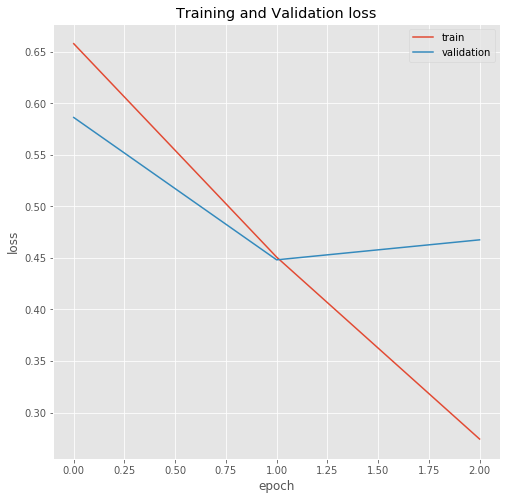

In [18]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
model.evaluate(X_train, y_train, verbose=False)

[0.17496715486049652,
 0.9473245739936829,
 0.9603919982910156,
 0.9148191213607788]

### Testing Model

In [20]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


,Negative,Positive
Negative,730,144
Positive,170,456


In [21]:
results

,Value
Accuracy,0.790667
Precision,0.760000
FPR,0.164760
Recall,0.728435
F1,0.743883


### Summary of Keras Embedding Layer
- The highest achievable accuracy is 79%.
- F1 score is 0.74.
- Recall and Precision are 72% and 76% respectively.
- Best performance is at batch size of 40.

# SimpleRNN+keras embedding layer

In [12]:
df = final_df.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [13]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [14]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,SpatialDropout1D

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           581350    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                7360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 588,775
Trainable params: 588,775
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_RNN_model = model.to_json()
with open('./NN_Models/keras_embed_RNN_model.json', 'w') as json_file:
    json_file.write(keras_embed_RNN_model)

model.save_weights('./NN_Models/keras_embed_RNN_model.h5')

print('saved model!')

Epoch 1/30
108/108 [==============================] - 10s 93ms/step - loss: 0.5935 - accuracy: 0.6831 - val_loss: 0.5349 - val_accuracy: 0.7533
Epoch 2/30
108/108 [==============================] - 7s 68ms/step - loss: 0.2724 - accuracy: 0.8976 - val_loss: 0.5649 - val_accuracy: 0.7817
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


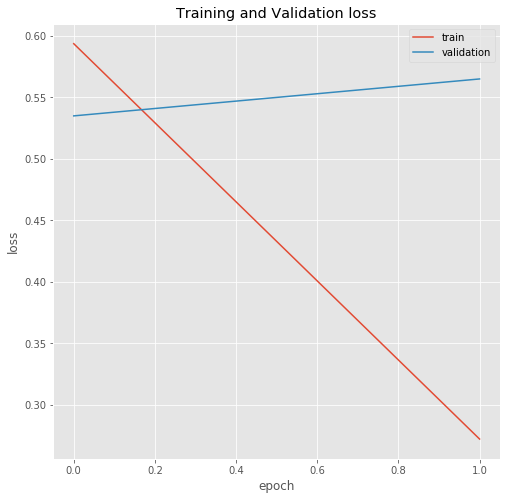

In [16]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [17]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


,Negative,Positive
Negative,692,182
Positive,198,428


In [18]:
results

,Value
Accuracy,0.746667
Precision,0.701639
FPR,0.208238
Recall,0.683706
F1,0.692557


### Summary of SimpleRNN + Keras Embedding Layer
- Model accuracy is around 77%
- Precision is 73%
- Recall is 71%
- F1 score is 0.72

# LSTM+keras embedding layer

In [19]:
df = final_df.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

In [20]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [21]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D, Bidirectional

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           581350    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 610,855
Trainable params: 610,855
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

lstm_keras_embed_model = model.to_json()
with open('./NN_Models/lstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(lstm_keras_embed_model)

model.save_weights('./NN_Models/lstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/30
108/108 [==============================] - 13s 118ms/step - loss: 0.5719 - accuracy: 0.6814 - val_loss: 0.4704 - val_accuracy: 0.7767
Epoch 2/30
108/108 [==============================] - 11s 103ms/step - loss: 0.3234 - accuracy: 0.8774 - val_loss: 0.4452 - val_accuracy: 0.8050
Epoch 3/30
108/108 [==============================] - 12s 109ms/step - loss: 0.2079 - accuracy: 0.9291 - val_loss: 0.5424 - val_accuracy: 0.7833
Epoch 00003: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


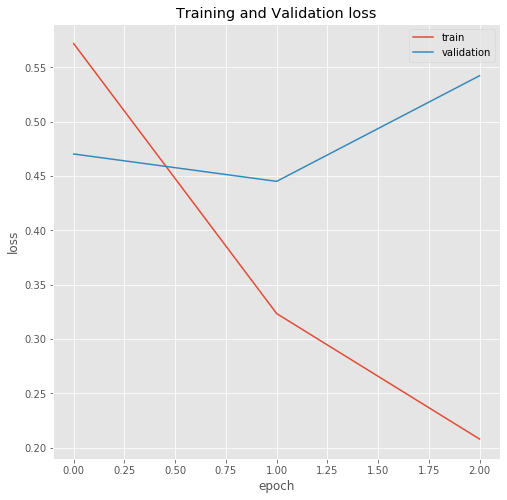

In [23]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [24]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,736,138
Positive,187,439


In [25]:
results

,Value
Accuracy,0.783333
Precision,0.760832
FPR,0.157895
Recall,0.701278
F1,0.729842


### Summary of LSTM+Keras Embedding Layer
- Model accuracy is around 78%
- Precision is 76%
- Recall is 70%
- F1 score is 0.73

# Bidirectional+keras embedding layer

In [28]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           581350    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 640,359
Trainable params: 640,359
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

blstm_keras_embed_model = model.to_json()
with open('./NN_Models/blstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(blstm_keras_embed_model)

model.save_weights('./NN_Models/blstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/30
108/108 [==============================] - 15s 143ms/step - loss: 0.5849 - accuracy: 0.6803 - val_loss: 0.4523 - val_accuracy: 0.7867
Epoch 2/30
108/108 [==============================] - 12s 109ms/step - loss: 0.3163 - accuracy: 0.8757 - val_loss: 0.4667 - val_accuracy: 0.8083
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


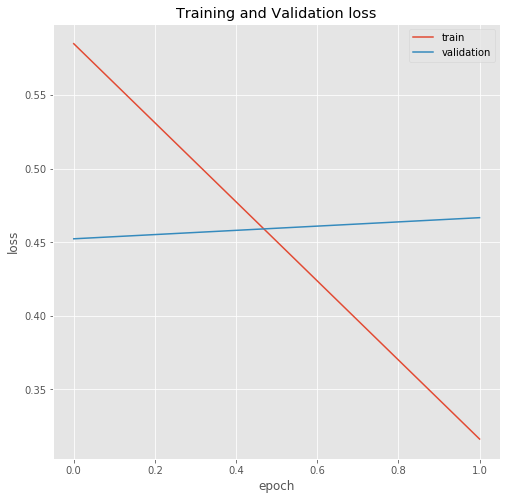

In [34]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [30]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,776,98
Positive,207,419


In [31]:
results

,Value
Accuracy,0.796667
Precision,0.810445
FPR,0.112128
Recall,0.669329
F1,0.733158


### Summary of BLSTM+Keras Embedding Layer
- Model accuracy is around 80%
- Precision is 81%
- Recall is 67%
- F1 score is 0.73

# Adding location Feature

In [32]:
# Location + texts
data_ = final_df.copy()
data_['tweets'] = data_['text'].str.cat(data_['location'],sep=" ")
# removing location and text column
data_.drop(columns=['location', 'text'], inplace=True, axis=1)
data_

,id,keyword,target,tweets
31,48,ablaze,1,bbcmtd wholesal market ablaz birmingham
32,49,ablaze,0,alway tri bring heavi metal rt est septemb bristol
33,50,ablaze,1,african baze break nigeria news flag set ablaz aba africa
34,52,ablaze,0,cri set ablaz philadelphia pa
35,53,ablaze,0,plu side look sky last night ablaz london unit kingdom
...,...,...,...,...
7604,10863,NaN,1,worldnew fallen powerlin glink tram updat fire crew evacu passeng tr canada
7605,10864,NaN,1,flip side im walmart bomb everyon evacu stay tune blow canada
7606,10866,NaN,1,suicid bomber kill saudi secur site mosqu reuter via world googl news wall canada
7608,10869,NaN,1,two giant crane hold bridg collaps nearbi home canada


In [35]:
df = data_.copy()

sentences = df['tweets'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[6])
print(X_train[6])

someon mention gansey firem bust brick wall seven differ build  taken piper curda 
[304, 1181, 5007, 5008, 2751, 3488, 909, 1722, 910, 40, 808, 5009, 5010]


In [37]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras import layers

embedding_dim = 40
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(64, kernel_initializer='he_normal', activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 40)           521240    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 523,929
Trainable params: 523,929
Non-trainable params: 0
_________________________________________________________________


In [38]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [39]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=40,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_model = model.to_json()
with open('./NN_Models/keras_embed_mlp_model.json', 'w') as json_file:
    json_file.write(keras_embed_model)

model.save_weights('./NN_Models/keras_embed_mlp_model.h5')

print('saved model!')

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
150/150 [==============================] - 6s 41ms/step - loss: 0.6584 - accuracy: 0.6039 - precision: 0.9756 - recall: 0.0778 - val_loss: 0.5904 - val_accuracy: 0.7220 - val_precision: 0.9035 - val_recall: 0.3738
Epoch 2/50
150/150 [==============================] - 5s 33ms/step - loss: 0.4357 - accuracy: 0.8395 - precision: 0.8880 - recall: 0.7157 - val_loss: 0.4679 - val_accuracy: 0.7900 - val_precision: 0.7704 - val_recall: 0.7077
Epoch 3/50
150/150 [==============================] - 4s 29ms/step - loss: 0.2436 - accuracy: 0.9080 - precision: 0.9198 - recall: 0.8604 - val_loss: 0.4991 - val_accuracy: 0.7840 - val_precision: 0.7420 - val_recall: 0.7396
Epoch 00003: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


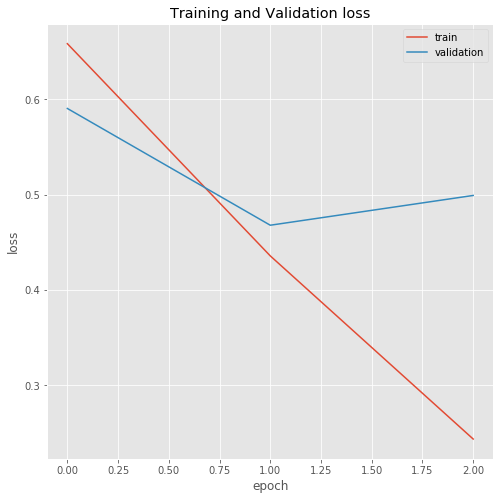

In [40]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [41]:
model.evaluate(X_train, y_train, verbose=False)

[0.13513031601905823,
 0.9621603488922119,
 0.9669322967529297,
 0.9439906477928162]

In [42]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,713,161
Positive,163,463


In [43]:
results

,Value
Accuracy,0.784000
Precision,0.741987
FPR,0.184211
Recall,0.739617
F1,0.740800


## Summary
- Model accuracy is around 78%
- Precision is 74%
- Recall is 74%
- F1 score is 0.74
- Dropout layers add have no impact on the model.
- Only few tweets (especially in Aus, USA, UK) may be affected by the location feature.

## Recurrent Neural Network

In [44]:
df = data_.copy()

sentences = df['tweets'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [45]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [46]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,SpatialDropout1D

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           651550    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                7360      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 658,975
Trainable params: 658,975
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_RNN_model = model.to_json()
with open('./NN_Models/keras_embed_RNN_model.json', 'w') as json_file:
    json_file.write(keras_embed_RNN_model)

model.save_weights('./NN_Models/keras_embed_RNN_model.h5')

print('saved model!')

Epoch 1/30
108/108 [==============================] - 9s 80ms/step - loss: 0.5855 - accuracy: 0.6974 - val_loss: 0.5285 - val_accuracy: 0.7600
Epoch 2/30
108/108 [==============================] - 7s 64ms/step - loss: 0.2579 - accuracy: 0.9089 - val_loss: 0.5800 - val_accuracy: 0.7333
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


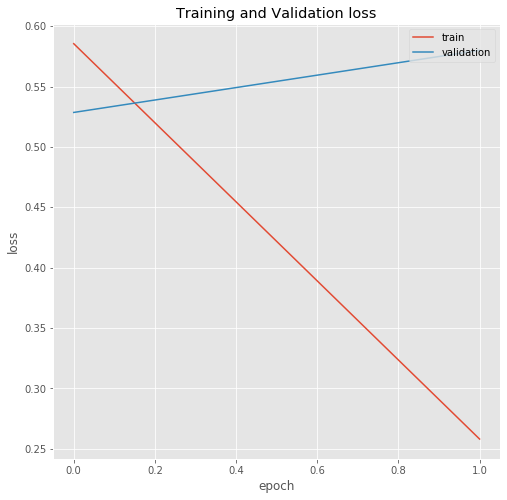

In [48]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,724,150
Positive,207,419


In [50]:
results

,Value
Accuracy,0.762000
Precision,0.736380
FPR,0.171625
Recall,0.669329
F1,0.701255


## Summary
- Model accuracy is around 76%
- Precision is 73%
- Recall is 67%
- F1 score is 0.7

## LSTM+Keras Embedding Layer

In [51]:
df = data_.copy()

sentences = df['tweets'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [52]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [53]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,LSTM,SpatialDropout1D, Bidirectional

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           651550    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 681,055
Trainable params: 681,055
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

lstm_keras_embed_model = model.to_json()
with open('./NN_Models/lstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(lstm_keras_embed_model)

model.save_weights('./NN_Models/lstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/30
108/108 [==============================] - 13s 119ms/step - loss: 0.5796 - accuracy: 0.6799 - val_loss: 0.4817 - val_accuracy: 0.7683
Epoch 2/30
108/108 [==============================] - 10s 94ms/step - loss: 0.3043 - accuracy: 0.8815 - val_loss: 0.5088 - val_accuracy: 0.7850
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


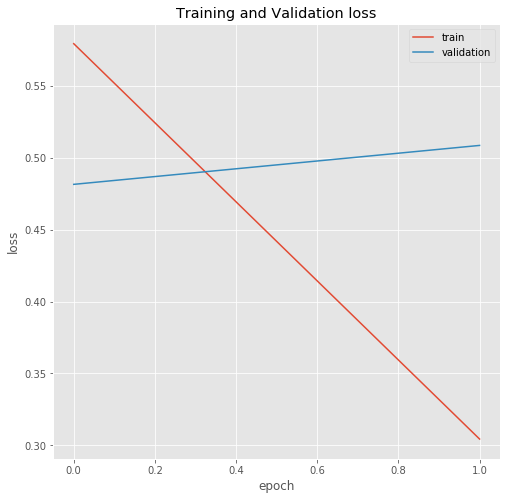

In [55]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [56]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,793,81
Positive,225,401


In [57]:
results

,Value
Accuracy,0.796000
Precision,0.831950
FPR,0.092677
Recall,0.640575
F1,0.723827


## Summary
- Model accuracy is around 80%
- Precision is 83%
- Recall is 64%
- F1 score is 0.72

# Bidirectional+keras embedding layer

In [58]:
df = data_.copy()

sentences = df['tweets'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [59]:
max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [60]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           651550    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 710,559
Trainable params: 710,559
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

blstm_keras_embed_model = model.to_json()
with open('./NN_Models/blstm_keras_embed_model.json', 'w') as json_file:
    json_file.write(blstm_keras_embed_model)

model.save_weights('./NN_Models/blstm_keras_embed_model.h5')

print('saved model!')

Epoch 1/30
108/108 [==============================] - 15s 142ms/step - loss: 0.5946 - accuracy: 0.6775 - val_loss: 0.4783 - val_accuracy: 0.7683
Epoch 2/30
108/108 [==============================] - 13s 123ms/step - loss: 0.3199 - accuracy: 0.8707 - val_loss: 0.4426 - val_accuracy: 0.8083
Epoch 3/30
108/108 [==============================] - 15s 136ms/step - loss: 0.1749 - accuracy: 0.9392 - val_loss: 0.5990 - val_accuracy: 0.7817
Epoch 00003: early stopping
saved model!


In [62]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,732,142
Positive,199,427


In [63]:
results

,Value
Accuracy,0.772667
Precision,0.750439
FPR,0.162471
Recall,0.682109
F1,0.714644


## Summary
- Model accuracy is around 77%
- Precision is 75%
- Recall is 68%
- F1 score is 0.71

# Model with removed missing location entries

In [12]:
# Dropping entries with missing locations
new_data = modified_data.copy()
new_data.dropna(subset=['location'], inplace=True)
new_data

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesal market ablaz,1
32,49,ablaze,Est. September 2012 - Bristol,alway tri bring heavi metal rt,0
33,50,ablaze,AFRICA,african baze break nigeria news flag set ablaz aba,1
34,52,ablaze,"Philadelphia, PA",cri set ablaz,0
35,53,ablaze,"London, UK",plu side look sky last night ablaz,0
...,...,...,...,...,...
7575,10826,wrecked,TN,bright side wreck,0
7577,10829,wrecked,#NewcastleuponTyne #UK,he gone relax thought wife wreck cake goner mind lol whoop,0
7579,10831,wrecked,"Vancouver, Canada",three day work theyv pretti much wreck hahaha shoutout famili one,0
7580,10832,wrecked,London,fx forex trade cramer iger word wreck disney stock,0


In [14]:
df = new_data.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[6])
print(X_train[6])

havent seen devast corp breach yet prepar get coverag 
[844, 590, 169, 2430, 3536, 591, 518, 4, 3537]


In [16]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras import layers

embedding_dim = 40
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(40, kernel_initializer='he_normal', activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 40)           363840    
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 365,521
Trainable params: 365,521
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=40,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_model = model.to_json()
with open('./NN_Models/keras_embed_mlp_model_without_missing_location_entries.json', 'w') as json_file:
    json_file.write(keras_embed_model)

model.save_weights('./NN_Models/keras_embed_mlp_model_without_missing_location_entries.h5')

print('saved model!')

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
101/101 [==============================] - 1s 14ms/step - loss: 0.6738 - accuracy: 0.5712 - precision: 0.9091 - recall: 0.0058 - val_loss: 0.6435 - val_accuracy: 0.6189 - val_precision: 0.9762 - val_recall: 0.0969
Epoch 2/50
101/101 [==============================] - 1s 9ms/step - loss: 0.5377 - accuracy: 0.7921 - precision: 0.9058 - recall: 0.5777 - val_loss: 0.4865 - val_accuracy: 0.7900 - val_precision: 0.7994 - val_recall: 0.6690
Epoch 3/50
101/101 [==============================] - 1s 9ms/step - loss: 0.3150 - accuracy: 0.8899 - precision: 0.9087 - recall: 0.8278 - val_loss: 0.4565 - val_accuracy: 0.7940 - val_precision: 0.7827 - val_recall: 0.7069
Epoch 4/50
101/101 [==============================] - 1s 9ms/step - loss: 0.1822 - accuracy: 0.9460 - precision: 0.9555 - recall: 0.9174 - val_loss: 0.4844 - val_accuracy: 0.7861 - val_precision: 0.7562 - val_recall: 0.7258
Epoch 00004: early sto

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


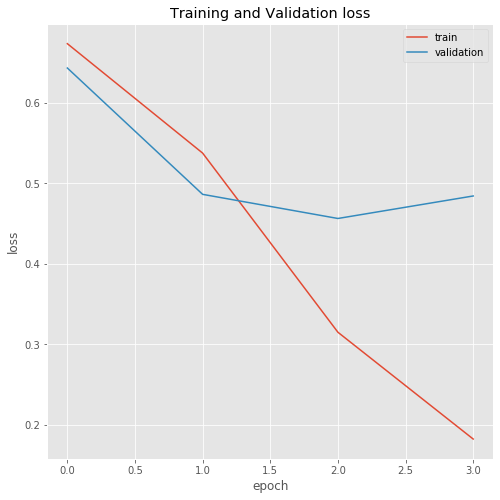

In [18]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
model.evaluate(X_train, y_train, verbose=False)

[0.1076926589012146, 0.9733565449714661, 0.981613278388977, 0.9560947418212891]

In [20]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


,Negative,Positive
Negative,483,99
Positive,116,307


In [21]:
results

,Value
Accuracy,0.786070
Precision,0.756158
FPR,0.170103
Recall,0.725768
F1,0.740651


# Model Summary
- Accuracy is 78.6%
- Precision is 75.5%
- Recall is 72.6%
- F1 is 74%

## SimpleRNN

In [22]:
df = new_data.copy()

sentences = df['text'].values
y = df['target'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.2, random_state=42, shuffle=True)

In [23]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test  = tokenizer.texts_to_sequences(sentences_test)

max_length = max([len(s.split()) for s in sentences])
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test =pad_sequences(X_test, maxlen=max_length, padding='post')

In [24]:
from keras import layers
from keras.layers import Dense,Dropout,Embedding,SpatialDropout1D

embedding_dim = 50
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(64,return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           454800    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                7360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 462,225
Trainable params: 462,225
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_split=0.1,
                    batch_size=50,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

keras_embed_RNN_model = model.to_json()
with open('./NN_Models/keras_embed_RNN_model_without_missing_location_entries.json', 'w') as json_file:
    json_file.write(keras_embed_RNN_model)

model.save_weights('./NN_Models/keras_embed_RNN_model_without_missing_location_entries.h5')

print('saved model!')

Epoch 1/30
73/73 [==============================] - 2s 23ms/step - loss: 0.6429 - accuracy: 0.6292 - val_loss: 0.5445 - val_accuracy: 0.7388
Epoch 2/30
73/73 [==============================] - 1s 20ms/step - loss: 0.2848 - accuracy: 0.8926 - val_loss: 0.6226 - val_accuracy: 0.7164
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


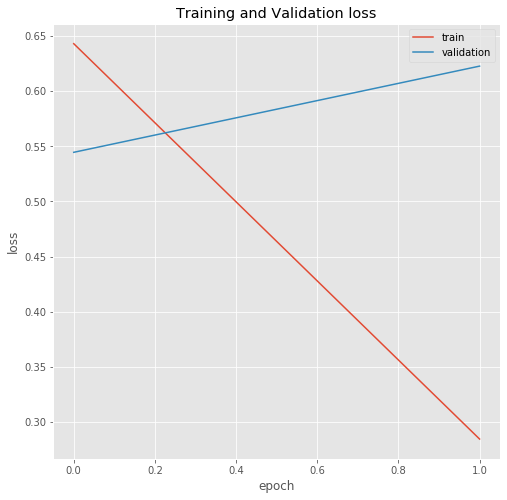

In [26]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,454,128
Positive,131,292


In [28]:
results

,Value
Accuracy,0.742289
Precision,0.695238
FPR,0.219931
Recall,0.690307
F1,0.692764


## Model Summary
- Accuracy is 74.2%
- Precision is 69.5%
- Recall is 69%
- F1 is 69.3%